In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sps
import pickle
from tqdm import tqdm
rng = np.random.default_rng()

In [2]:
from graph import RandomGraph, plot_trajectories

In [3]:
%load_ext autoreload
%autoreload 2

В этой части работы $H_i \sim \mathcal{N}(0, \Sigma)$, а все внедиагональные элементы матрицы ковариаций $\Sigma$ равны одному и тому же фиксированному числу $\beta$. Посмотрим на динамику систем с различными топологиями сети:
* полный граф
* кольцо
* дерево Кэли степени 3

Конечно, возможных топологий очень много. Можно было попробовать работать с $k$-дольными графами, произвольными деревьями, графом-бабочкой, кактусами и т.д., но для начала посмотрим на перечисленные выше.

Для разных графов придётся выбирать разной константу связи $J$: нужно, чтобы величина $J \cdot \sum\limits_{i: (i, j) \in E} \sigma_i$, отвечающая взаимодействию, совпадала по порядку с величиной собственного поля, которое оказывается в основном из $[-1, 1]$.

## Полный граф

In [4]:
N = 5000
J = 0.0003
G_complete = RandomGraph(N, topology='complete')

In [5]:
beta_grid = np.linspace(0, 0.9, 10)
H_max = 4
H_grid = np.linspace(-H_max, H_max, 400)
history = {"low_to_high": [], "high_to_low":[], "hubs_low":[], "hubs_high":[]}

In [58]:
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low, hubs_low, hubs_high = G_complete.get_trajectories(J, H_grid, beta,
                                                                                'multivariate_norm', True,
                                                                                matrix='simple')
    history["low_to_high"].append(low_to_high)
    history["high_to_low"].append(high_to_low)
    history["hubs_low"].append(hubs_low)
    history["hubs_high"].append(hubs_high)
    
with open('complete.pkl', 'wb') as handle:
    pickle.dump(history, handle)

10it [25:15, 151.58s/it]


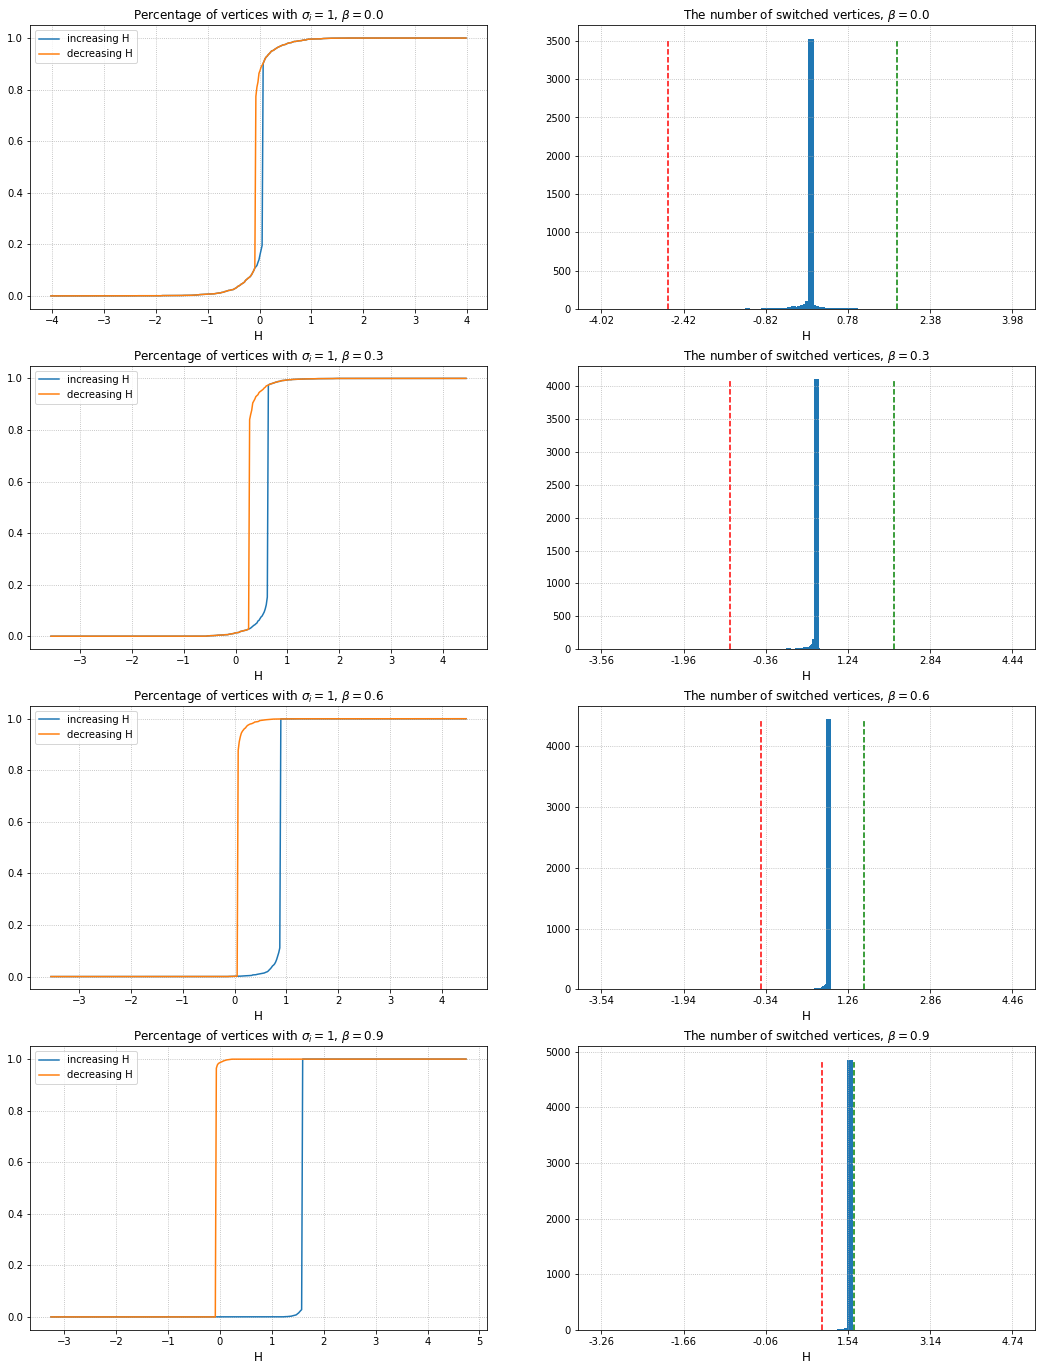

In [6]:
positions = [0, 3, 6, 9]
plt.figure(figsize=(18, 6 * len(positions)))
with open('complete.pkl', 'rb') as handle:
    history = pickle.load(handle)

for index, beta in enumerate(beta_grid[positions]):
    plot_trajectories(index, len(positions), beta, H_grid,
                      history["low_to_high"][positions[index]], history["high_to_low"][positions[index]],
                      history["hubs_low"][positions[index]], history["hubs_high"][positions[index]])

Для петли гистерезиса можно посчитать различные характеристики:
* Ширина. Петлю гистерезиса можно описать двумя функциями $f_{up}(H)$ и $f_{down}(H)$ — долями агентов с положительной стратегией при увеличении внешнего воздействия и при уменьшении. В таком случае будем называть её шириной величину $W = \max\limits_{e \in (0, 1)} f_{up}^{-1}(e) - f_{down}^{-1}(e)$, где $f^{-1}(e) = \inf \{x \mid f(x) = e\}$.  


* Площадь: $S = \int\limits_{\mathbb{R}} f_{down}(x) - f_{up}(x)\,dx$.

* Диапазон перехода: $T = \inf \{x \mid f_{up}(x) = 1\} - \sup \{x \mid f_{up}(x) = 0\}$.

* Среднее и максимальное количество агентов, меняющих своё состояние за 1 шаг.

Диапазон перехода:

In [15]:
H_test = np.linspace(1, 2, num=11)
test_steps = np.array([0, 0, 0, 0, 0.1, 0.4, 0.7, 0.8, 0.9, 1, 1])
inv_test_steps = np.flip(np.array([1, 1, 1, 1, 0.9, 0.6, 0.3, 0.2, 0.1, 0, 0]))
agents_test = 5000

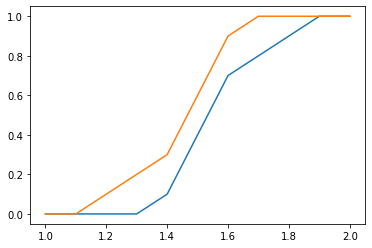

In [119]:
plt.plot(H_test, test_steps)
plt.plot(H_test, inv_test_steps)

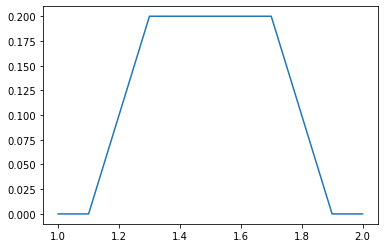

In [126]:
plt.plot(H_test, inv_test_steps - test_steps);

In [7]:
def transition_range(steps, H_steps):
    return H_steps[np.argmax(steps)] - H_steps[np.where(steps > 0)[0][0] - 1]

In [114]:
assert np.allclose(transition_range(test_steps, H_test), 0.6)

Среднее и максимальное количество агентов в переходе:

In [16]:
def agents_numbers(steps, N):
    diff = steps[1:] - steps[:-1]
    agents = diff[diff > 0] * N
    return np.mean(agents), np.max(agents)

In [17]:
assert np.allclose(agents_numbers(test_steps, N), (N / 6, 0.3 * N))

Ширина:

In [9]:
def width(low_to_high, high_to_low, H_steps, eps=1e-6):
    """
    high_to_low перевёрнуто, т.е. увеличивается от 0 до 1
    """
    N = len(H_steps)
    cnt, res = 0, 0
    for i in range(N):
        if low_to_high[i] < eps or 1 - low_to_high[i] < eps:
            continue
        while high_to_low[cnt] <= low_to_high[i]:
            cnt += 1
        res = max(res, H_steps[i] - H_steps[cnt - 1])
    return res

In [123]:
assert np.allclose(width(test_steps, inv_test_steps, H_test), 0.2)

Площадь:

In [10]:
def square(low_to_high, high_to_low, H_steps):
    """
    high_to_low перевёрнуто, т.е. увеличивается от 0 до 1
    """
    diff = high_to_low - low_to_high 
    step = H_steps[1] - H_steps[0]
    heights = (diff[1:] + diff[:-1]) / 2
    return np.sum(heights) * step

In [128]:
assert np.allclose(square(test_steps, inv_test_steps, H_test), 0.12)

In [18]:
def get_history_lists(beta_grid, history):
    tr, mean_agents, max_agents, widths, squares = [], [], [], [], []
    for index, beta in enumerate(beta_grid):
        lth = np.array(history["low_to_high"][index])
        htl = np.flip(history["high_to_low"][index])
        tr.append(transition_range(lth, H_grid))
        mean_ag, max_ag = agents_numbers(lth, N)
        mean_agents.append(mean_ag)
        max_agents.append(max_ag)
        widths.append(width(lth, htl, H_grid))
        squares.append(square(lth, htl, H_grid))
    return tr, mean_agents, max_agents, widths, squares

In [19]:
tr, mean_agents, max_agents, widths, squares = get_history_lists(beta_grid, history)

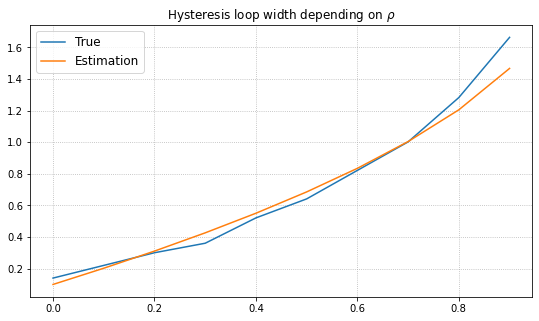

In [20]:
plt.figure(figsize=(9, 5))
plt.grid(ls=':')
plt.plot(beta_grid, widths, label='True')

plt.plot(beta_grid, 1.4 * J * N - 2 * np.sqrt(1 - beta_grid), label='Estimation')
plt.title(r'Hysteresis loop width depending on $\rho$')
plt.legend(fontsize='large');

In [21]:
def plot_all(beta_grid, tr, mean_agents, max_agents, squares):
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    for i in range(2):
        for j in range(2):
            axes[i][j].grid(ls=':')
    axes[0][0].plot(beta_grid, tr)
    axes[0][0].set_title('Transition range')
    axes[0][1].plot(beta_grid, mean_agents)
    axes[0][1].set_title('Mean agents switched during one step')
    axes[1][1].plot(beta_grid, max_agents)
    axes[1][1].set_title('Max agents switched during one step')
    axes[1][0].plot(squares);
    axes[1][0].set_title('Hysteresis loop area');

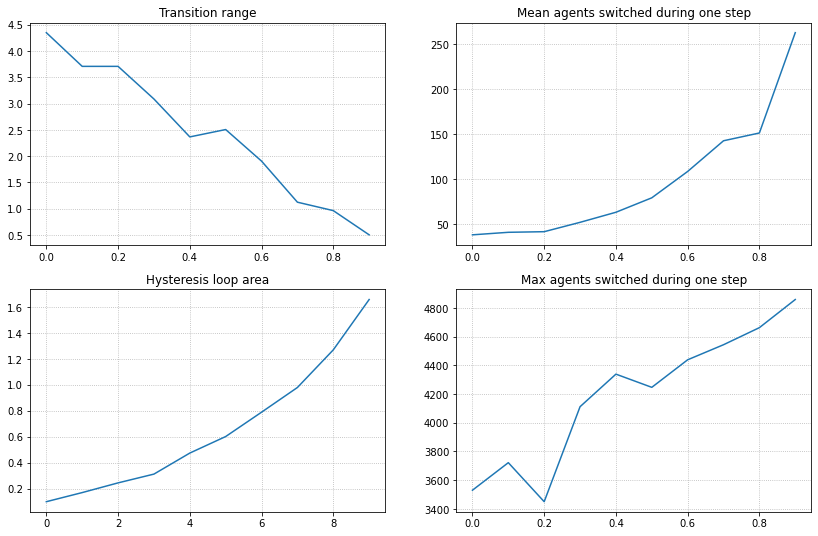

In [22]:
plot_all(beta_grid, tr, mean_agents, max_agents, squares)

Довольно хорошо видно, что петля гистерезиса постепенно расширяется, превращаясь в конце концов в прямоугольник, и её границы становятся более резкими. На гистограмме это соответствует увеличению высоты пика и практически полному исчезновению столбиков около него. На первый взгляд, это довольно необычный эффект, поскольку из-за корреляций отдельные поля становятся ближе друг к другу. Формально, уменьшается дисперсия разности двух случайных величин:

$$
    \text{В отсутствие корреляций } D_0 = \mathsf{D}(\xi_1 - \xi_2) = \mathsf{E}(\xi_1 - \xi_2)^2 = \mathsf{E}\xi_1^2 + \mathsf{E}\xi_2^2 - 2 \mathsf{E}\xi_1 \xi_2 = \mathsf{E}\xi_1^2 + \mathsf{E}\xi_2^2 - 2 \mathsf{E}\xi_1 \cdot \mathsf{E}\xi_2 \\
    \text{При наличии корреляций } D_1 = \mathsf{D}(\xi_1 - \xi_2) = \mathsf{E}\xi_1^2 + \mathsf{E}\xi_2^2 - 2 \mathsf{E}\xi_1 \xi_2 = \mathsf{E}\xi_1^2 + \mathsf{E}\xi_2^2 - 2 \mathsf{E}\xi_1 \cdot \mathsf{E}\xi_2 - 2 \mathsf{cov}(\xi_1, \xi_2) < D_0
$$

Поэтому можно было бы ожидать, напротив, сужения петли гистерезиса -- но происходит обратное. Почему?

Пусть система находится в состоянии со средним спином $M$ и внешним полем $H$. Попытаемся получить выражение для матожидания производной среднего спина $\frac{dM}{dH}$. Увеличим поле на малую величину $dH$. Тогда возможны два варианта:
* На интервале $(-JM-H-dH; -JM-H)$ не оказалось ни одной вершины. Тогда ситуация никак не изменится.
* На интервале $(-JM-H-dH; -JM-H)$ оказались вершины. В таком случае $M$ изменится: случится лавина, средний размер которой будет зависеть от текущей ситуации (т.е. от $M$ и $H$).

Вероятность "активации", т.е. реализации второго варианта, равна 

$$
    \mathrm{P}_a = 1 - \mathrm{P} \bigl\{ f_1, \dots, f_N \notin (-JM-H-dH, -JM-H) \bigr\}
$$

Найдём матожидание размера лавины во втором случае.

Здесь, увы, не получится считать распределение количества вершин, попадающих в определённый отрезок, биномиальным или пуассоновским, как это происходит в одномерном случае — придётся честно выписывать вероятности, поскольку отдельные поля $f_i$ зависимы.

Рассмотрим для каждой вершины её эффективное поле: $F_i^{eff} = JM + H + f_i$. Заметим, что $\sigma_i = \mathrm{sign} \left(F_i^{eff} \right)$, а также то, что переворот одной вершины увеличивает эффективное поле всех других на $\frac{2J}{N}$.  
Поэтому, чтобы случилась лавина размера $s$, необходимо, чтобы в полуинтервале $\left[f_i - 2\frac{Js}{N}; f_i \right)$ оказалось в точности $s - 1$ вершин, где $f_i \approx -JM - H$ — поле первого спина, уже нашедшегося по предположению.

Помимо этого, они должны быть выстроены так, чтобы образовывать лавину: переворот первого должен вызывать переворот как минимум второго, переворот второго — переворот третьего и т.д. 

Такое происходит ровно в $\frac{1}{s}$ случаев. Чтобы понять это, "свернём" отрезок $\left[f_i - 2\frac{Js}{N}; f_i \right]$ в кольцо и будем считать, что поля увеличиваются так же, как в $\mathbb{Z}_p$, т.е. увеличению поля соответствует поворот на определённый угол (например, $(f_i - \varepsilon) + 2\varepsilon = f_i - 2\frac{Js}{N} + \varepsilon$). Теперь имеется $s$ спинов на кольце (расположенных произвольным образом), и $s$ возможных их нумераций по порядку (каждый из них можно выбрать первым). Подходящей, т.е. такой, при которой спины выстраиваются в лавину, является ровно одна из таких нумераций. Остаётся заметить, что "<i>выбрать $s$ спинов произвольно, а затем выбрать нумерацию</i>" и "<i>выбрать $1$ спин произвольно, назвать его первым, а потом выбрать ещё $s - 1$ спинов произвольно</i>" — одно и то же. Поэтому распределение по размерам лавин будет таким:

$$
    \mathrm{P}(s) = \frac{1}{s} \cdot \mathrm{P}\left\{ \text{ровно $s - 1$ спинов попали в $\left[f_i - 2\frac{Js}{N}; f_i \right)$} \right\}
$$

Найдём эту вероятность. Обозначим $[N] = {1, 2, \dots, N}$, тогда

$$
    \mathrm{P}\left\{ \text{ровно $s - 1$ спинов попали в $\left[f_i - 2\frac{Js}{N}; f_i \right)$} \right\} = \sum_{A_{s - 1} \subseteq [N]} \mathrm{P} \left\{ f_{a_1}, \dots, f_{a_{s - 1}} \in \left[f_i - 2\frac{Js}{N}; f_i \right), f_{\bar a_1}, \dots f_{\bar a_{N - s + 1}} \notin \left[f_i - 2\frac{Js}{N}; f_i \right) \right\}.
$$

Здесь $A_{s - 1} = \{a_1, \dots, a_{s - 1}\}$ — произвольное $(s-1)$-элементное подножество $[N]$ (суммирование идёт по всем таким подмножествам), а $\bar A_{s - 1} = \{\bar a_1, \dots, \bar a_{N - s + 1}\}$ — его дополнение. Проще говоря, здесь мы перебираем варианты: какие из $f_i$ попадут в полуинтервал, а какие — нет.

Поскольку все вершины равноправны, все такие вероятности оказываются равны, и 

$$
    \mathrm{P}\left\{ \text{ровно $s - 1$ спинов попали в $\left[f_i - 2\frac{Js}{N}; f_i \right)$} \right\} = 
    \frac{1}{s} \cdot C_N^{s - 1} \cdot 
    \mathrm{P} \left\{ f_{1}, \dots, f_{s - 1} \in \left[f_i - 2\frac{Js}{N}; f_i \right), f_{s}, \dots f_{N} \notin \left[f_i - 2\frac{Js}{N}; f_i \right) \right\}.
$$

Обозначим последнюю вероятность за $Q_{s - 1}$:

$$
    Q_{s - 1} = \frac{1}{(2\pi)^{\frac{s - 1}{2}}|\Sigma|^{\frac{1}{2}}} 
    \int\limits_{\left[f_i - 2\frac{Js}{N}; f_i \right)^{s-1}}\,dx_1\dots dx_{s-1} 
    \int\limits_{\left( \mathbb{R} \backslash \left[f_i - 2\frac{Js}{N}; f_i \right) \right)^{N - s + 1}}\mathrm{exp}\left\{ -\frac12 x^T \Sigma^{-1} x \right\} \, dx_s\dots dx_N
$$

Здесь

$$
    \Sigma = \begin{pmatrix}
        1 & \rho & \dots & \rho \\
        \rho & 1 & \dots & \rho \\
        \vdots & & \ddots & \vdots \\
        \rho & \dots & \rho & 1
    \end{pmatrix}, 
    \:
    \Sigma^{-1} = \frac{1}{(1-\rho)(1 + \rho(N-1))}\begin{pmatrix}
        1 + \rho(N-2)& -\rho & \dots & -\rho \\
        -\rho & 1 + \rho(N-2) & \dots & -\rho \\
        \vdots & & \ddots & \vdots \\
        -\rho & \dots & -\rho & 1 + \rho(N-2)
    \end{pmatrix}, 
    \\
    |\Sigma| = \left(1 + \rho(N-1)\right)(1-\rho)^{N-1}.
$$

Посмотрим на выражение в показателе экспоненты:

$$
    x^T \Sigma^{-1} x = \frac{1}{(1-\rho)(1 + \rho(N-1))} \biggl( (1+\rho(N-2)) \sum_{i = 1}^N x_i^2 - \rho \sum_{i \ne j} x_i x_j \biggr) = \frac{1}{(1-\rho)(1 + \rho(N-1))} \biggl( (1+\rho(N-1)) \sum_{i = 1}^N x_i^2 - \rho \biggl( \sum_{i=1}^N x_i \biggr)^2 \biggr) = \\
    = \frac{1}{1 - \rho} \biggl( \sum_{i = 1}^N x_i^2 - \frac{\rho}{1+\rho(N-1)} \biggl( \sum_{i=1}^N x_i \biggr)^2 \biggr)
$$

Оно, как видно, сильно зависит от соотношения между $\sum\limits_{i = 1}^N x_i^2$ и $\biggl( \sum\limits_{i=1}^N x_i \biggr)^2$ — для произвольного $x$ второе выражение окажется, скорее всего, околонулевым, и плотность будет убывать с ростом $\rho$; для тех же $x$, где все $x_i$ равны, слагаемые будут убивать друг друга, и плотность будет расти. Хорошо это заметно на следующих цветовых картах:

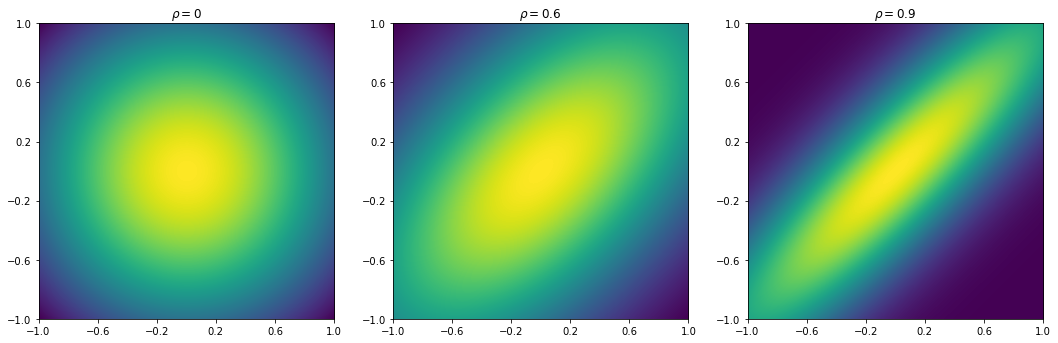

In [94]:
rho_grid = [0, 0.6, 0.9]
plt.figure(figsize=(18, 5.5))
for index, rho in enumerate(rho_grid):
    s = np.ones((2, 2)) * rho + np.eye(2) * (1 - rho)
    meshgrid = np.meshgrid(np.linspace(1, -1, 1000), np.linspace(-1, 1, 1000))
    meshgrid = np.transpose(meshgrid, (1, 2, 0))
    Z = sps.multivariate_normal.pdf(meshgrid, mean=np.zeros(2), cov=s)
    plt.subplot(1, 3, index + 1)
    plt.title(r'$\rho = {}$'.format(rho))
    plt.imshow(Z, extent=(-1, 1, -1, 1))
    plt.xticks(np.linspace(-1, 1, 6))
    plt.yticks(np.linspace(-1, 1, 6))

Таким образом, с ростом корреляций плотность распределения оказывается сосредоточенной вблизи линий вида $f_1 = f_2 = \dots = f_N$, и окончательно 

$$
    dM = \frac1N \bigl( 1 - \mathrm{P} \bigl\{ f_1, \dots, f_N \notin (-JM-H-dH, -JM-H) \bigr\} \bigr) \cdot \sum_{s = 1}^N C_N^{s-1} Q_{s-1}
$$

При больших корреляциях происходит примерно следующее. 
1. При генерации выборки отдельные поля вершин оказываются близки друг к другу: пусть $f_1, \dots f_N$ сгенерировались около $F^*$.
2. Из-за этого активации не происходит до того, пока не окажется $F^* \in (-JM-H-dH, -JM-H)$, т.е. $H \approx J - F^*$ (изначально $M \approx -1$). C этим как раз и связан эффект запаздывания.
3. Когда активация, наконец, происходит, размер лавины оказывается большим — из-за того, что вершины оказываются близко друг к другу, получается, что сразу много вершин оказываются на промежутках вида $\left[f_i - 2\frac{Js}{N}; f_i \right)$ (даже для малых $s$).

Теперь надём ширину полосы между траекториями. Для этого заметим, что $\mathrm{E}f_i f_j = \rho + \delta_{ij}(1 - \rho)$, и 

$$
    \mathrm{E} \biggl( f_i - \frac{\sum_{k = 1}^N f_k}{N} \biggr)^2 = \mathrm{E} \biggl( f_i^2 - \frac{2f_i\sum_{k = 1}^N f_k}{N} + \frac{\bigl( \sum_{k = 1}^N f_k \bigr)^2}{N^2} \biggr) = 1 - \frac2N \cdot (1 + \rho(N-1)) + \frac{1}{N^2} \left( N + \rho\cdot N(N-1) \right) \approx \\
    \approx 1 - 2\rho + \rho = 1 - \rho.
$$

Т.е. можно считать, что вершины сгенерированы около $F^*$ с разбросом $\sqrt{1 - \rho}$. Тогда при увеличении $H$ переход начинается при $JM + H + F^* + \sqrt{1 - \rho} = 0$, т.е. при $H_{up} \approx J - F^* - \sqrt{1 - \rho}$ (изначально $M \approx -1$), а при движении в обратную сторону — при $H_{down} \approx -J - F^* + \sqrt{1 - \rho}$. Соответственно, ширина полосы составит $H_{up} - H_{down} = 2J - 2\sqrt{1 - \rho}$ — она увеличивается с ростом $\rho$, как и получается на практике.

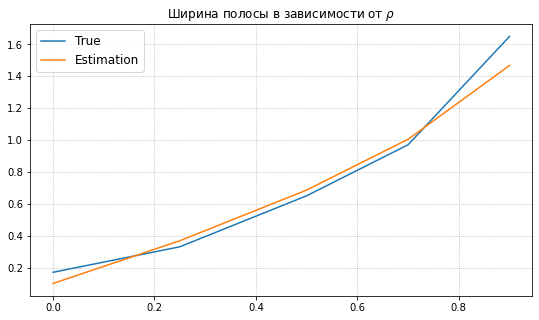

In [16]:
y = [0.17, 0.33, 0.65, 0.97, 1.65]
plt.figure(figsize=(9, 5))
plt.grid(ls=':')
plt.plot(beta_grid, y, label='True')

plt.plot(beta_grid, 1.4 * J * N - 2 * np.sqrt(1 - beta_grid), label='Estimation')
plt.title(r'Ширина полосы в зависимости от $\rho$')
plt.legend(fontsize='large');
# Здесь используется поправка в виде коэф. 1.4, т.к. на самом деле M ≠ +-1 в начале перехода.
# Без неё один из графиков получается сдвинут на константу вверх.

## Кольцо

In [23]:
N = 5000
J = 0.5
G_circle = RandomGraph(N, topology='circle')
history = {"low_to_high": [], "high_to_low":[], "hubs_low":[], "hubs_high":[]}

In [162]:
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low, hubs_low, hubs_high = G_circle.get_trajectories(J, H_grid, beta, 
                                                                            'multivariate_norm', True,
                                                                            matrix='simple')
    history["low_to_high"].append(low_to_high)
    history["high_to_low"].append(high_to_low)
    history["hubs_low"].append(hubs_low)
    history["hubs_high"].append(hubs_high)
    
with open('circle.pkl', 'wb') as handle:
    pickle.dump(history, handle)


10it [49:18, 295.88s/it]


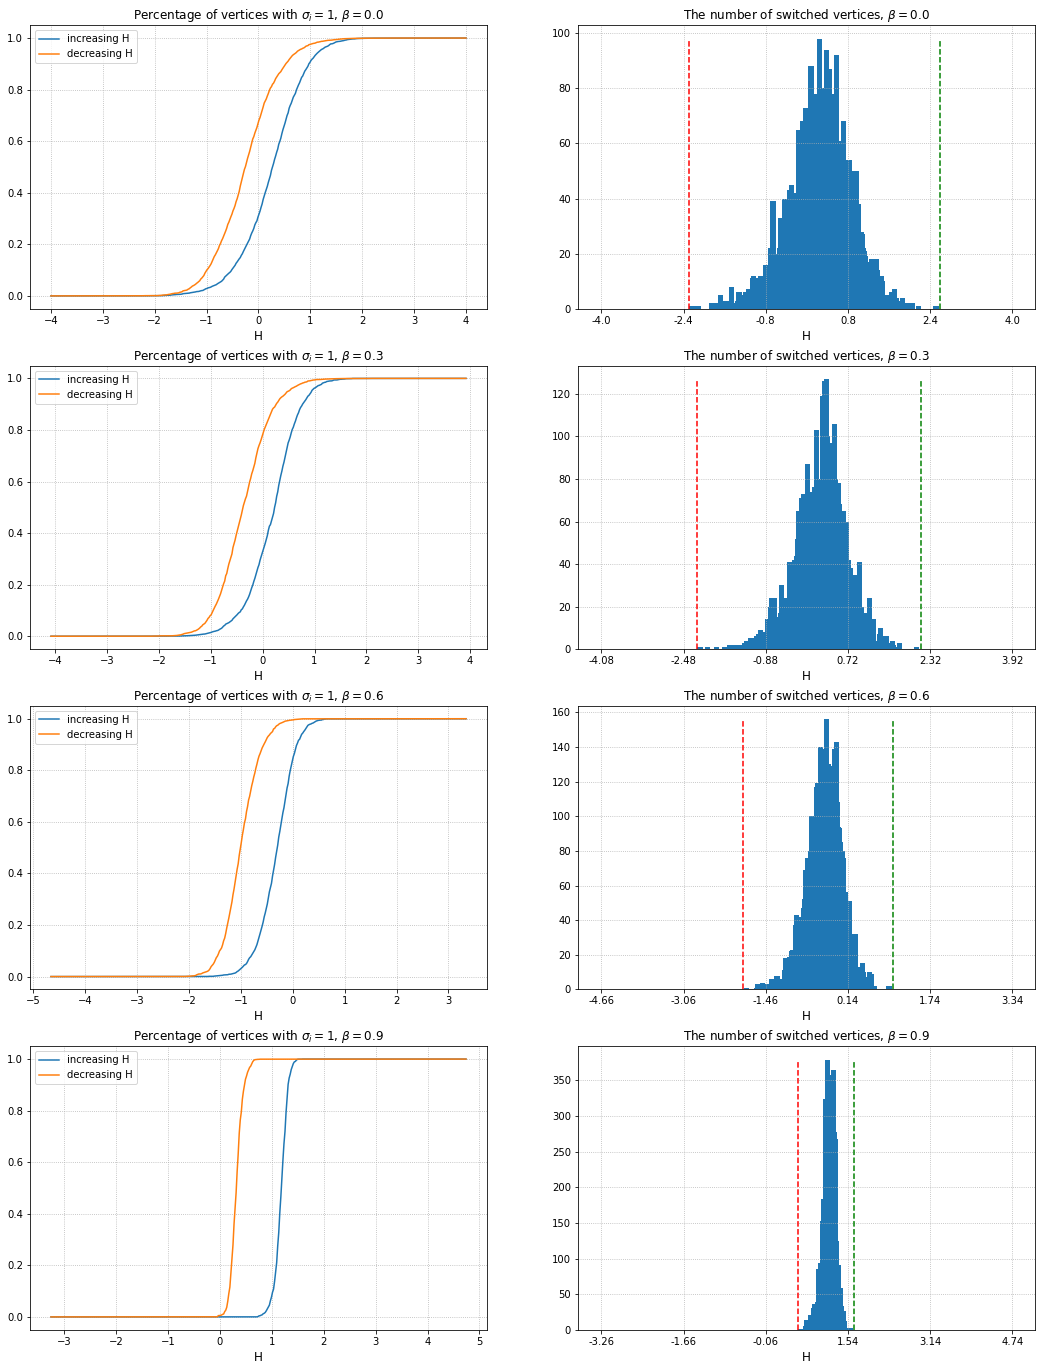

In [24]:
positions = [0, 3, 6, 9]
plt.figure(figsize=(18, 6 * len(positions)))
with open('circle.pkl', 'rb') as handle:
    history = pickle.load(handle)

for index, beta in enumerate(beta_grid[positions]):
    plot_trajectories(index, len(positions), beta, H_grid,
                      history["low_to_high"][positions[index]], history["high_to_low"][positions[index]],
                      history["hubs_low"][positions[index]], history["hubs_high"][positions[index]])

In [25]:
tr, mean_agents, max_agents, widths, squares = get_history_lists(beta_grid, history)

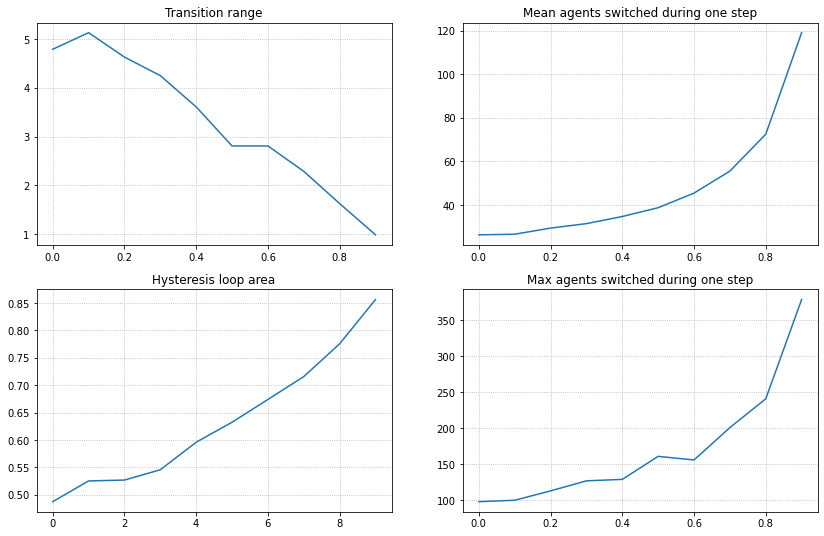

In [26]:
plot_all(beta_grid, tr, mean_agents, max_agents, squares)

Как и в случае полного графа, переходы становятся более резкими, а столбики на гистограмме — более тесно локализованными. Это происходит, конечно, из-за уменьшения разницы между отдельными соседними полями $H_i$. Однако и здесь увеличивается расстояние между прямой и обратной траекториями.

## Дерево Кэли (q = 3)

In [27]:
N = 5000
J = 1
G_tree = RandomGraph(N, topology='cayley_tree')
history = {"low_to_high": [], "high_to_low":[], "hubs_low":[], "hubs_high":[]}

In [168]:
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low, hubs_low, hubs_high = G_tree.get_trajectories(J, H_grid, beta, 
                                                                            'multivariate_norm', True,
                                                                            matrix='simple')
    history["low_to_high"].append(low_to_high)
    history["high_to_low"].append(high_to_low)
    history["hubs_low"].append(hubs_low)
    history["hubs_high"].append(hubs_high)
    
with open('cayley.pkl', 'wb') as handle:
    pickle.dump(history, handle)

10it [40:50, 245.01s/it]


Ситуация похожа на то, что происходит в случае кольца, но чуть более слабо выражена: даже при больших корреляциях ($\beta \sim 0{,}9$) полоса, в которой осуществляются переходы, остаётся достаточно широкой.

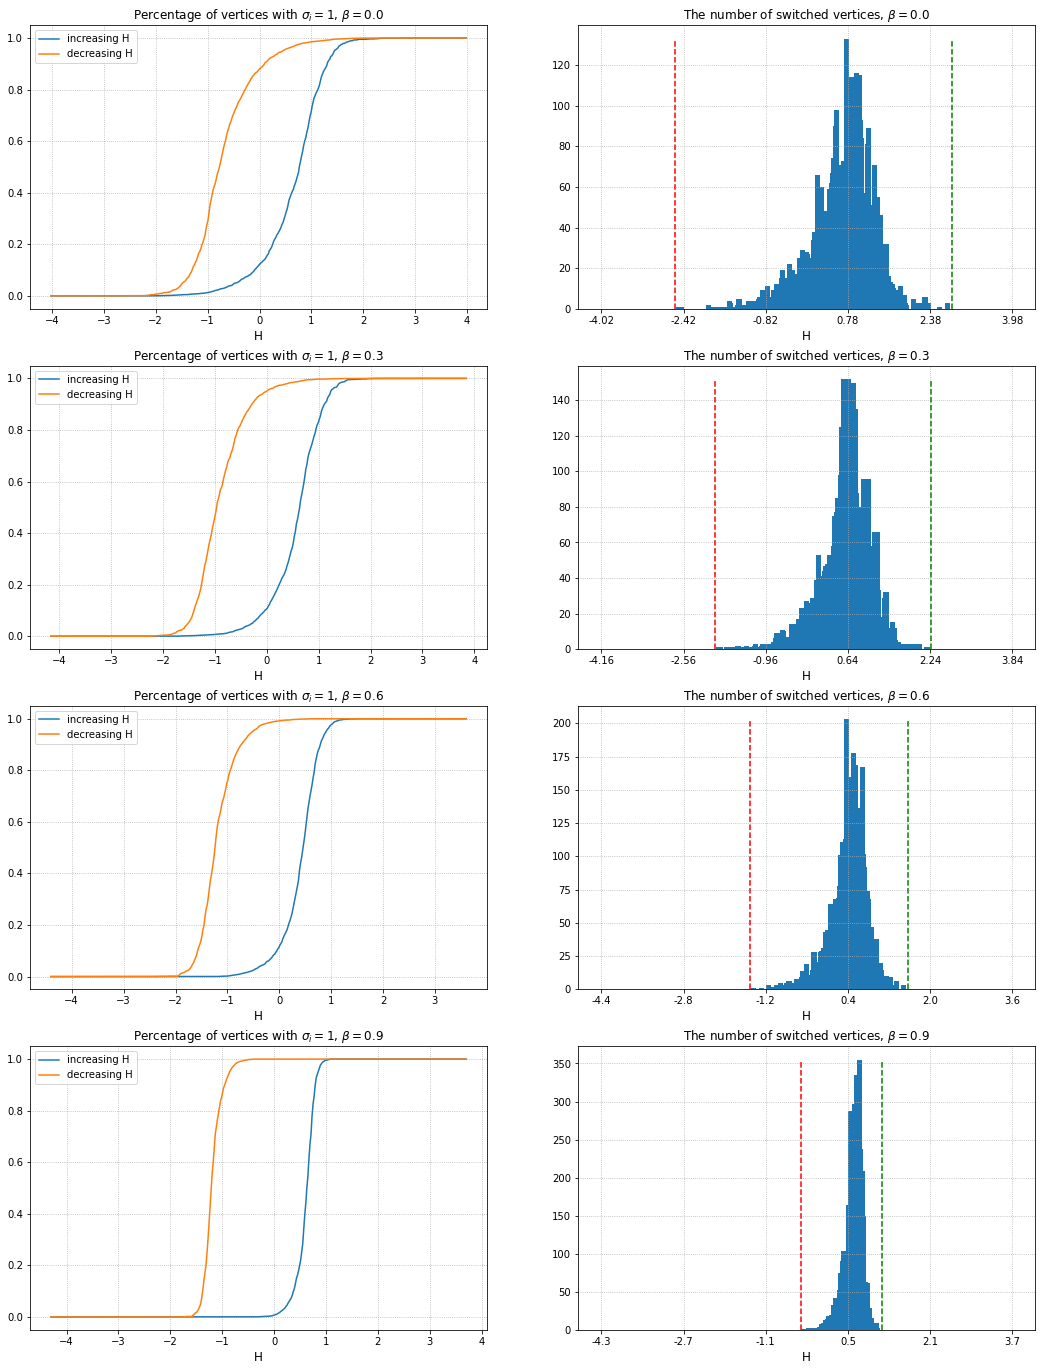

In [28]:
positions = [0, 3, 6, 9]
plt.figure(figsize=(18, 6 * len(positions)))
with open('cayley.pkl', 'rb') as handle:
    history = pickle.load(handle)

for index, beta in enumerate(beta_grid[positions]):
    plot_trajectories(index, len(positions), beta, H_grid,
                      history["low_to_high"][positions[index]], history["high_to_low"][positions[index]],
                      history["hubs_low"][positions[index]], history["hubs_high"][positions[index]])

In [29]:
tr, mean_agents, max_agents, widths, squares = get_history_lists(beta_grid, history)

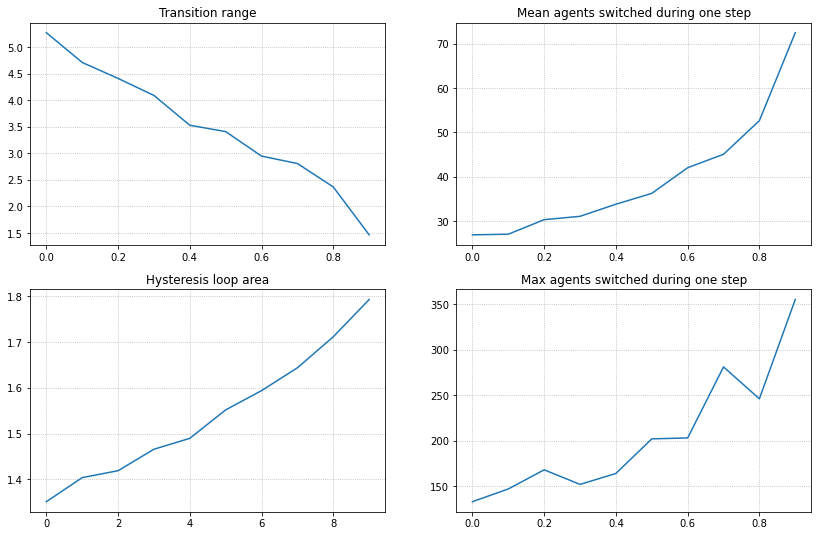

In [30]:
plot_all(beta_grid, tr, mean_agents, max_agents, squares)